In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import timm
from fastai.vision.all import *
from tqdm.notebook import tqdm
import sklearn.feature_extraction.text
from transformers import (BertTokenizer, AutoConfig, AutoModel)
from sklearn.model_selection import StratifiedKFold
import regex

In [3]:
base_path = 'data'
# base_path = '../data'

BERT_PATH = base_path + '/bert-indo-15g'

bert_model_file = base_path + '/saved_models/text_model/fine_tune_5epoch_bertindo15g-bs-64-mgrad-m06-08.pth'

image_model_file = base_path + '/saved_models/fine_tune_5epoch_nfnetl0-bs-64-pre-mgrad-adaptconcat-embed-1024-m08-10.pth'


In [4]:
# thees are thresholds used for Neighborhood Blending
RECIPROCAL_THRESHOLD = .97
MIN_PAIR_THRESHOLD = .6

## Bert Model

In [ ]:
class InferenceClassifier(nn.Module):
    def __init__(self, emb, thresh,min2):
        super().__init__()
        self.emb = emb
        self.thresh = thresh
        self.min2 = min2

    def forward(self, x):
        dists = self.emb @ F.normalize(x).T
        top_vals, top_inds = dists.topk(50, dim=0, sorted=True)
        if top_vals[0][0] < min2:
            return (torch.tensor([]), torch.tensor([]))
        top_vals = top_vals[ top_vals[top_vals < self.thresh]] 
        top_inds = top_inds[ top_inds[top_vals < self.thresh]] 
        return (top_inds, top_vals)

In [5]:
class BertArcFace(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert_model = AutoModel.from_pretrained(BERT_PATH)
        self.classifier = None
    def forward(self, x):
        output = self.bert_model(x)
        return output.last_hidden_state[:,0,:]

In [6]:
def load_bert_model(fname,emb,thresh):
    model = BertArcFace()
    state = torch.load(fname)
    model.load_state_dict(state)

    return model

### Dataloader for Bert

In [7]:
#Taken from https://www.kaggle.com/c/shopee-product-matching/discussion/233605#1278984
def string_escape(s, encoding='utf-8'):
    return s.encode('latin1').decode('unicode-escape').encode('latin1').decode(encoding)

class TitleTransform(Transform):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained(BERT_PATH)
               
    def encodes(self, row):
        text = row.title
        text=string_escape(text)
        encodings = self.tokenizer(text, padding = 'max_length', max_length=100, truncation=True,return_tensors='pt')
        keys =['input_ids', 'attention_mask', 'token_type_ids'] 
        return tuple(encodings[key].squeeze() for key in keys)

def get_text_dls(bs=256):
    tfm = TitleTransform()

    data_block = DataBlock(
        blocks = (TransformBlock(type_tfms=tfm), 
                  CategoryBlock(vocab=train_df.label_group.to_list())),
        splitter=ColSplitter(),
        get_y=ColReader('label_group'),
        )
    return  data_block.dataloaders(train_df, bs=bs)

## IMAGE

In [8]:
class ArcFaceNet(nn.Module):
    def __init__(self, arch, embedding_size=512, classifier=None):
        super().__init__()
        self.body = create_body(arch, cut=-2)
        nf = num_features_model(nn.Sequential(*self.body.children()))      
        self.after_conv=nn.Sequential(
                AdaptiveConcatPool2d(),
                Flatten(),
                nn.Linear(nf*2,embedding_size),
                nn.BatchNorm1d(embedding_size)
            )       

        self.classifier = classifier if classifier is not None else None

    def forward(self, x):
        x = self.body(x)
        return self.after_conv(x)


In [9]:
def load_image_model(fname):
    state_dict = torch.load(fname)
    arch = timm.create_model("eca_nfnet_l0", pretrained = False)
    model = ArcFaceNet(arch=arch, embedding_size=1024)
    model.load_state_dict(state_dict)
    model = model.eval().cuda()
    return model

In [10]:
def get_img_file(row):
    img =row.image
    fn  = PATH/'train_images'/img
    if not fn.is_file():
        fn = PATH/'test_images'/img
    return fn

def get_image_dls(size, bs):
    data_block = DataBlock(blocks = (ImageBlock(), CategoryBlock(vocab=train_df.label_group.to_list())),
                 splitter=ColSplitter(),
                 get_y=ColReader('label_group'),
                 get_x=get_img_file,
                 item_tfms=Resize(int(size*1.5), resamples=(Image.BICUBIC,Image.BICUBIC)), 
                 batch_tfms=aug_transforms(size=size, min_scale=0.75)+[Normalize.from_stats(*imagenet_stats)],
                 )
    return data_block.dataloaders(train_df, bs=bs)



## Helper code

In [11]:

def add_target_groups(data_df, source_column='label_group', target_column='target'):
    target_groups = data_df.groupby(source_column).indices
    data_df[target_column]=data_df[source_column].map(target_groups)
    return data_df

def add_splits(train_df, valid_group=0):
    grouped = train_df.groupby('label_group').size()

    labels, sizes =grouped.index.to_list(), grouped.to_list()

    skf = StratifiedKFold(5)
    splits = list(skf.split(labels, sizes))

    group_to_split =  dict()
    for idx in range(5):
        labs = np.array(labels)[splits[idx][1]]
        group_to_split.update(dict(zip(labs, [idx]*len(labs))))

    train_df['split'] = train_df.label_group.replace(group_to_split)
    train_df['is_valid'] = train_df['split'] == valid_group
    return train_df

def embs_from_model(model, dl):
    all_embs = []
    all_ys=[]
    for batch in tqdm(dl):
        if len(batch) ==2:
            bx,by=batch
        else:
            bx,=batch
            by=torch.zeros(1)
        with torch.no_grad():
            embs = model(bx)
            all_embs.append(embs)
        all_ys.append(by)
    all_embs = torch.cat(all_embs)
    return all_embs, torch.cat(all_ys)

def get_targets_shape(train_df):
    all_targets = add_target_groups(train_df).target.to_list()
    all_targets_lens = [len(t) for t in all_targets]
    targets_shape = []
    for size in range(min(all_targets_lens), max(all_targets_lens)+1):
        count = all_targets_lens.count(size) / len(all_targets)
        targets_shape.append((size,count))
    return targets_shape

def chisel(groups, groups_p, pos, target_count):
    probs = []
    groups_lens = [len(g)for g in groups]
    current_count = groups_lens.count(pos)
    if current_count >= target_count:

        return
    to_cut = target_count - current_count
    for i in range(len(groups)):
        if len(groups_p[i])>pos:
            probs.append((i, groups_p[i][pos]))
    probs.sort(key=lambda x:x[1])
    for i in range(min(to_cut, len(probs))):
        group_idx = probs[i][0] 
        groups[group_idx]=groups[group_idx][:pos]
        groups_p[group_idx]=groups_p[group_idx][:pos]

In [12]:

def sorted_pairs(distances, indices):
    triplets = []
    n= len(distances)
    for x in range(n):
        used=set()
        for ind, dist in zip(indices[x].tolist(), distances[x].tolist()):
            if not ind in used:
                triplets.append((x, ind, dist))
                used.add(ind)
    return sorted(triplets, key=lambda x: -x[2])

def do_chunk(embs):
    step = 1000
    for chunk_start in range(0, embs.shape[0], step):
        chunk_end = min(chunk_start+step, len(embs))
        yield embs[chunk_start:chunk_end]
        
def get_nearest(embs, emb_chunks, K=None, sorted=True):
    if K is None:
        K = min(51, len(embs))
    distances = []
    indices = []
    for chunk in emb_chunks:
        sim = embs @ chunk.T
        top_vals, top_inds = sim.topk(K, dim=0, sorted=sorted)
        distances.append(top_vals.T)
        indices.append(top_inds.T)
    return torch.cat(distances), torch.cat(indices)

def combined_distances(embs_list):
    K = min(len(embs_list[0]), 51)
    combined_inds =[get_nearest(embs, do_chunk(embs))[1] for embs in embs_list]
    combined_inds = torch.cat(combined_inds, dim=1)
    res_inds,res_dists = [],[]
    for x in range(len(combined_inds)):
        inds = combined_inds[x].unique()
        Ds = [embs[None,x] @ embs[inds].T for embs in embs_list]
        D = Ds[0] + Ds[1] - Ds[0] * Ds[1]
        top_dists, top_inds = D.topk(K)
        res_inds.append(inds[top_inds])
        res_dists.append(top_dists)
    return torch.cat(res_inds), torch.cat(res_dists)

def blend_embs(embs_list, threshold, m2_threshold, data_df):
    combined_inds, combined_dists = combined_distances(embs_list)
    check_measurements(combined_dists, combined_inds, data_df)
    new_embs_list = L((torch.empty_like(embs) for embs in embs_list))
    for x in range(len(embs_list[0])):
        neighs = combined_dists[x] > threshold
        if neighs.sum() == 1 and combined_dists[x][1]>m2_threshold:
            neighs[1]=1
        neigh_inds, neigh_ratios = combined_inds[x, neighs], combined_dists[x,neighs]
        for embs, new_embs in zip(embs_list, new_embs_list):
            new_embs[x] = (embs[neigh_inds] * neigh_ratios.view(-1,1)).sum(dim=0)
    return new_embs_list.map(F.normalize)

In [13]:
# Not used in solution, just for illustration purpose
def f1(tp, fp, num_tar):
    return 2 * tp / (tp+fp+num_tar)

def build_from_pairs(pairs, target, display = True):
    score =0
    tp = [0]*len(target)
    fp = [0]*len(target)
    scores=[]
    vs=[]
    group_sizes = [len(x) for x in target]
    for x, y, v in pairs:
        group_size = group_sizes[x]
        score -= f1(tp[x], fp[x], group_size)
        if y in target[x]: tp[x] +=1
        else: fp[x] +=1
        score += f1(tp[x], fp[x], group_size) 
        scores.append(score / len(target))
        vs.append(v)
    if display:
        plt.plot(scores)
        am =torch.tensor(scores).argmax()
        print(f'{scores[am]:.3f} at {am/len(target)} pairs or {vs[am]:.3f} threshold')
    return scores


def score_distances(dist, targets, display=False):
    triplets = dist_to_edges(dist)[:len(dist)*10]
    return max(build_from_pairs(triplets, targets, display))

def score_group(group, target):
    tp = len(set(group).intersection(set(target)))
    return 2 * tp / (len(group)+len(target))
def score_all_groups(groups, targets):
    scores = [score_group(groups[i], targets[i]) for i in range(len(groups))]
    return sum(scores)/len(scores)
def show_groups(groups, targets):
    groups_lens = [len(g)for g in groups]
    targets_lens = [len(g) for g in targets]
    plt.figure(figsize=(8,8)) 
    plt.hist((groups_lens,targets_lens) ,bins=list(range(1,52)), label=['preds', 'targets'])
    plt.legend()
    plt.title(f'score: {score_all_groups(groups, targets):.3f}')
    plt.show()

### Helper code for units of measurement matching

In [14]:
measurements = {
    'weight': [('mg',1), ('g', 1000), ('gr', 1000), ('gram', 1000), ('kg', 1000000)],
    'length': [('mm',1), ('cm', 10), ('m',1000), ('meter', 1000)],
    'pieces': [ ('pc',1)],
    'memory': [('gb', 1)],
    'volume': [('ml', 1), ('l', 1000), ('liter',1000)]
}

def to_num(x, mult=1):
    x = x.replace(',','.')
    return int(float(x)*mult)

def extract_unit(tit, m):
    pat = f'\W(\d+(?:[\,\.]\d+)?) ?{m}s?\W'
    matches = regex.findall(pat, tit, overlapped=True)
    return set(matches)

def extract(tit):

    res =dict()
    tit = ' '+tit.lower()+' '
    for cat, units in measurements.items():
        cat_values=set()
        for unit_name, mult in units:
            values = extract_unit(tit, unit_name)
            values = {to_num(v, mult) for v in values}
            cat_values = cat_values.union(values)
        if cat_values:
            res[cat] = cat_values
    return res

def add_measurements(data):
    data['measurement'] = data.title.map(extract)
    return data

def match_measures(m1, m2):
    k1,k2 = set(m1.keys()), set(m2.keys())
    common = k1.intersection(k2)
    if not common: return True
    for key in common:
        s1,s2 = m1[key], m2[key]
        if s1.intersection(s2):
            return True
    return False

def check_measurements(combined_dists, combined_inds, data_df):
    K = min(8, len(data_df)) * len(data_df)
    _, inds_k = combined_dists.view(-1).topk(K)
    removed = 0
    inds_k = inds_k.tolist()
    for idx in inds_k:
        x = idx // combined_inds.shape[1]
        y_idx = idx % combined_inds.shape[1]
        y = combined_inds[x,y_idx] 
        if not match_measures(data_df.iloc[x].measurement, data_df.iloc[y.item()].measurement):
            removed +=1
            combined_dists[x][y_idx]=0
    print('removed', removed, 'matches')

### FAISS INB

In [37]:
import numpy as np
import faiss


def neighborhood_search(emb,thresh=0.85,min2_thresh=0.0,k_neighbors=51):
    
    emb = emb.cpu().numpy()
    
    index = faiss.IndexFlatIP(emb.shape[1])
    
    index.add(emb)
    
    
    sim, idx = index.search(emb, k_neighbors)
    sim_thresh = sim.copy()
    idx_thresh = idx.copy()
    sim_thresh[sim < thresh] = 0
    idx_thresh[sim < thresh] = -1

    sim_thresh[sim[:,1] > min2_thresh,1] = sim[sim[:,1] > min2_thresh,1]
    idx_thresh[sim[:,1] > min2_thresh,1] = idx[sim[:,1] > min2_thresh,1]
    return idx_thresh, sim_thresh

def unset_pad(x,pad = -999):
    x[x == pad] = 0 
    return x

def revert_pad(ids, pad = -999):
    return  np.array([ unset_pad(x,pad) for x in ids],dtype='object')


def push_all_pad_back(a, pad = -999):
    valid_mask = a!= pad
    flipped_mask = valid_mask.sum(1,keepdims=1) > np.arange(a.shape[1]-1,-1,-1)
    flipped_mask = flipped_mask[:,::-1]
    a[flipped_mask] = a[valid_mask]
    a[~flipped_mask] = pad
    return a


def join_similarities(join_idx,join_sim,other_idx,other_sim):
    other_ins = np.array([np.in1d(x,y) for x,y in zip(other_idx,join_idx)])
    other_sim[other_ins] = 0
    other_idx[other_ins] = -1
    union_idx = push_all_pad_back(np.hstack([join_idx,other_idx]), -1)
    union_sim = push_all_pad_back(np.hstack([join_sim,other_sim]), 0)
    return union_idx, union_sim

def join_similarity_set(join_idx,join_sim,img_idx, img_sim,bert_idx, bert_sim):
    union_idx , union_sim = join_similarities(join_idx, join_sim, img_idx, img_sim)
    union_idx , union_sim = join_similarities(union_idx, union_sim, bert_idx, bert_sim)
    return union_idx, union_sim

def trim_pad(union_idx, union_sim, id_pad=-999):
    union_idx[union_idx == 0] = id_pad
    union_idx[union_idx == -1] = 0
    union_idx = np.array([np.trim_zeros(x,'b') for x in union_idx],dtype='object')
    union_sim = np.array([np.trim_zeros(x,'b') for x in union_sim],dtype='object')
    union_idx = revert_pad(union_idx, id_pad)
    return union_idx, union_sim

def combine_embeddings(join_emb,img_emb,bert_emb,threshes = [1.0,0.85,0.85]):
    join_idx, join_sim =  neighborhood_search(join_emb,threshes[0])
    img_idx, img_sim = neighborhood_search(img_emb,threshes[1])
    bert_idx, bert_sim =  neighborhood_search(bert_emb,threshes[2])

    union_idx , union_sim = join_similarities(bert_idx.copy(), bert_sim.copy(), img_idx.copy(), img_sim.copy())
    # union_idx, union_sim = join_similarity_set(bert_idx.copy(), bert_sim.copy(), img_idx.copy(), img_sim.copy(), join_idx.copy(),join_sim.copy())
    union_idx, union_sim = trim_pad(union_idx, union_sim)
    new_emb = blend_neighborhood(join_emb,union_idx,union_sim)
    # new_emb =None
    return (img_idx, img_sim), (bert_idx, bert_sim ), (join_idx, join_sim), (union_idx , union_sim), new_emb
    
    
    

def blend_neighborhood(emb, match_index_lst, similarities_lst):
    new_emb = emb.clone()
    for i in tqdm(range(emb.shape[0])):
        if match_index_lst[i].shape != similarities_lst[i].shape:
            print(f'data no {i}: id shape {match_index_lst[i].shape} != sim shape {similarities_lst[i].shape} ')
            break
        cur_emb = emb[match_index_lst[i]]
        
        weights = torch.from_numpy(similarities_lst[i]).unsqueeze_(1).cuda()
        
        new_emb[i] = (cur_emb * weights).sum(axis=0)
        
    new_emb = F.normalize(new_emb)
    
    return new_emb



def iterative_neighborhood_blending(emb, threshes,k_neighbors=51):
    for thresh in threshes:
        match_index_lst, similarities_lst = neighborhood_search(emb, thresh,k_neighbors)
        if thresh == threshes[-1]:
            break
        emb = blend_neighborhood(emb, match_index_lst, similarities_lst)
    
    return emb,match_index_lst,similarities_lst

def check_joins(ids,sims):
    print('Starting...')
    if ids.shape != sims.shape:
        print('amount of sims and ids not the same')
    n = ids.shape[0]
    for i in tqdm(range(n)):
        if ids[i].shape != sims[i].shape:
            print(f'data no {i}: id shape {ids[i].shape} != sim shape {sims[i].shape} ')
    print('done')

In [16]:
def to_matches(pred_ids,df):
    preds = []
    for ids in pred_ids:

        o = df.iloc[ids].posting_id.values
        preds.append(o)
    return preds

def getMetric(col):
    def f1score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return 2*n / (len(row.target)+len(row[col]))
    return f1score

In [38]:
def threshold_searching(df, embeddings, LB=4.0, UB=6.0, mode='normal'):
    
    thresholds = list(np.arange(LB, UB + 0.01, 0.05))
    scores = []
    for threshold in thresholds:
        if mode == 'normal':
            id , sim = neighborhood_search(embeddings,threshold)
        elif mode == 'iterative':
            _, id , sim =iterative_neighborhood_blending(embeddings,[threshold,threshold])
        id, sim = trim_pad(id, sim)
        matches = to_matches(id,df)
        df['matches'] = matches
        MyCVScore = df.apply(getMetric('matches'), axis=1)
        score = MyCVScore.mean()
        print(f'CV score for threshold {threshold} = {score}')
        scores.append(score)
    thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})
    max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
    best_threshold = max_score['thresholds'].values[0]
    best_score = max_score['scores'].values[0]
    print(f'Our best score is {best_score} and has a threshold {best_threshold}')
        
    
    return best_threshold

## Check on validation set

In [18]:
train_df = pd.read_csv( base_path + '/train.csv')
train_df = add_splits(train_df)
tmp = train_df.groupby('label_group').posting_id.agg('unique').to_dict()
train_df['target'] = train_df.label_group.map(tmp)
# train_df=add_measurements(train_df)

valid_df = train_df[train_df.is_valid==True]
# valid_df=add_measurements(valid_df)


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [19]:
# ys = torch.from_numpy(train_df[[ 'label_group']].to_numpy())
# set_size = len(img_embs)
# target_matrix= ys[:,None]==ys[None,:]
# targets = [torch.where(t)[0].tolist() for t in target_matrix] 

### Generating embeddings from Resnet and BERT

In [20]:
# img_embs, ys = embs_from_model(load_image_model(image_model_file), get_image_dls(224, 128).valid)

# bert_embs, ys = embs_from_model(load_bert_model(bert_model_file), get_text_dls().valid)
img_embs = torch.load('data/saved_embeddings/image_embeddings/fine_tune_5epoch_nfnetl0-bs-64-pre-mgrad-adaptconcat-embed-1024-m08-10.pth').cuda()
bert_embs = torch.load('data/saved_embeddings/text_embeddings/fine_tune_5epoch_bertindo15g-bs-64-mgrad-m06-08_embed.pth').cuda()


In [21]:
img_embs = F.normalize(img_embs)
bert_embs = F.normalize(bert_embs)

**This is the score we'd get by simply taking all matches above a fixed threshold:**

In [20]:


# combined_inds, combined_dists = combined_distances([img_embs, bert_embs])

In [21]:
# def_pairs = sorted_pairs(combined_dists, combined_inds)
# _=build_from_pairs(def_pairs[:10*len(combined_inds)], targets)

**This is the score after Neighborhood Blending:**

In [22]:
# # new_embs = blend_embs([F.normalize(img_embs), F.normalize(bert_embs)], RECIPROCAL_THRESHOLD, MIN_PAIR_THRESHOLD, valid_df)
# new_embs = blend_embs([img_embs, bert_embs], RECIPROCAL_THRESHOLD, MIN_PAIR_THRESHOLD, train_df)


# combined_inds, combined_dists = combined_distances(new_embs)



In [23]:
# pairs = sorted_pairs(combined_dists, combined_inds)
# _=build_from_pairs(pairs[:10*len(combined_inds)], targets)

**This is the score after FAISS Neighborhood Blending:**

In [ ]:
best_img_thresh = threshold_searching(train_df.copy(),img_embs,0.4,0.95)

CV score for threshold 0.4 = 0.7156288014533663
CV score for threshold 0.45 = 0.7615298848614773
CV score for threshold 0.5 = 0.7770765262542256
Our best score is 0.7770765262542256 and has a threshold 0.5


In [ ]:
best_bert_thresh = threshold_searching(train_df.copy(),bert_embs,0.4,0.95)

In [33]:

# join_embs = torch.cat([img_embs, bert_embs], dim=1)
join_embs = torch.cat([bert_embs, img_embs], dim=1)
img_res, bert_res, join_res, union_res, comb_join_embs = combine_embeddings(join_emb=join_embs,img_emb=img_embs,
                                bert_emb=bert_embs, threshes=[1.0,best_img_thresh,best_bert_thresh])
# img_res, bert_res, join_res, union_res, comb_join_embs = combine_embeddings(join_emb=join_embs,img_emb=img_embs,
#                                 bert_emb=bert_embs, threshes=[1.0,0.6,0.9])
# join_embs, _, _  = iterative_neighborhood_blending(join_embs.cpu().numpy(), [0.92,0.96,0.99] , 51)



  0%|          | 0/34250 [00:00<?, ?it/s]

In [40]:
# best_blend_thresh = threshold_searching(train_df.copy(),comb_join_embs,0.4,0.95,'iterative')
best_blend_thresh = threshold_searching(train_df.copy(),comb_join_embs,0.8,0.85,'iterative')


CV score for threshold 0.8 = 0.8699401177383663
CV score for threshold 0.8500000000000001 = 0.8787817899497263
Our best score is 0.8787817899497263 and has a threshold 0.8500000000000001


In [41]:
blend_join_embs, match_index_lst,similarities_lst  = iterative_neighborhood_blending(comb_join_embs, [best_blend_thresh,best_blend_thresh])

In [278]:
blend_bert_embs = blend_join_embs[:,:768]
blend_img_embs = blend_join_embs[:,768:]

In [ ]:
best_blend_img_thresh = threshold_searching(train_df.copy(),blend_img_embs,0.4,0.95)

In [ ]:
best_blend_bert_thresh = threshold_searching(train_df.copy(),blend_bert_embs,0.4,0.95)

### Removing false positives based on measurements

removed 5568 matches
0.890 at 6.068992614746094 pairs or 0.975 threshold


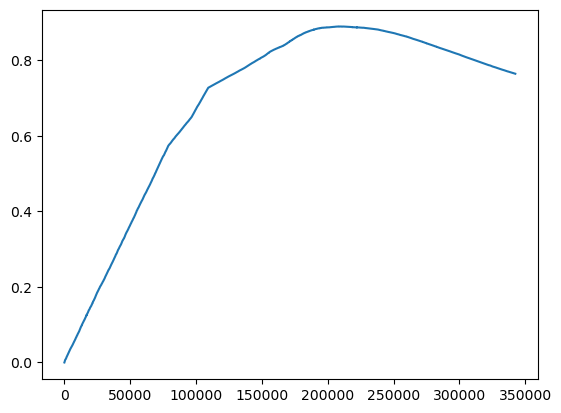

In [ ]:
# check_measurements(combined_dists, combined_inds, train_df)
# pairs = sorted_pairs(combined_dists, combined_inds)
# _=build_from_pairs(pairs[:10*len(combined_inds)], targets)

### Here we perform the chisel step to match the two distributions
This doesn't help here where we already have good matches, the effect is more pronounced on the test set where the initial grouping is further apart from the target

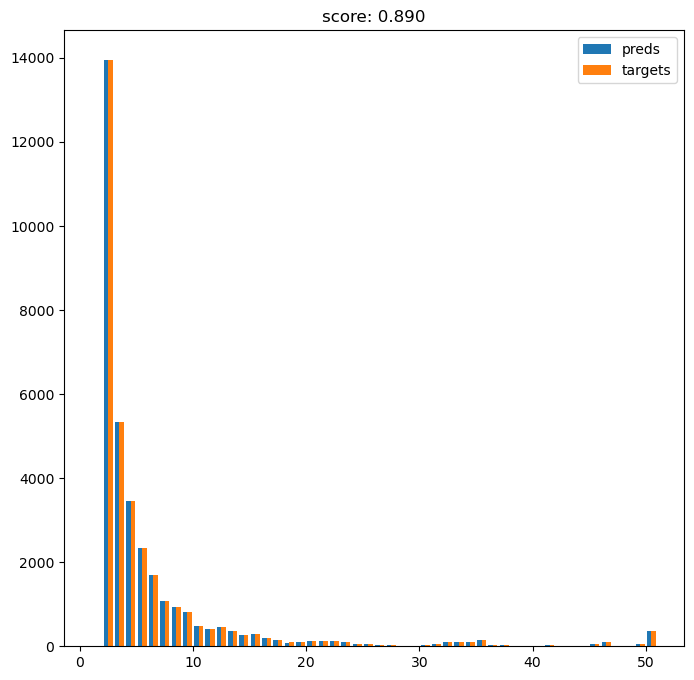

In [ ]:
# groups = [[] for _ in range(set_size)]
# groups_p = [[] for _ in range(set_size)]
# for x,y,v in pairs:
#     groups[x].append(y)
#     groups_p[x].append(v)
# for pos, size_pct in get_targets_shape(train_df):
#     chisel(groups, groups_p, pos, int(size_pct * len(groups)))
# show_groups(groups, targets)

## Run on the test set
same as above, just without displaying stuff.

In [46]:
def neighborhood_search_inference(ref_emb,query_emb, thresh=0.85,min2_thresh=0.1,k_neighbors=51):
    
    ref_emb = ref_emb.cpu().numpy()
    query_emb = query_emb.cpu().numpy()
    index = faiss.IndexFlatIP(ref_emb.shape[1])
    
    index.add(ref_emb)
    
    
    sim, idx = index.search(query_emb, k_neighbors)
    sim_thresh = sim.copy()
    idx_thresh = idx.copy()
    sim_thresh[sim < thresh] = 0
    idx_thresh[sim < thresh] = -1

    sim_thresh[sim[:,1] > min2_thresh,1] = sim[sim[:,1] > min2_thresh,1]
    idx_thresh[sim[:,1] > min2_thresh,1] = idx[sim[:,1] > min2_thresh,1]
    return idx_thresh, sim_thresh

# def unset_pad(x,pad = -999):
#     x[x == pad] = 0 
#     return x

# def revert_pad(ids, pad = -999):
#     return  np.array([ unset_pad(x,pad) for x in ids],dtype='object')


# def push_all_pad_back(a, pad = -999):
#     valid_mask = a!= pad
#     flipped_mask = valid_mask.sum(1,keepdims=1) > np.arange(a.shape[1]-1,-1,-1)
#     flipped_mask = flipped_mask[:,::-1]
#     a[flipped_mask] = a[valid_mask]
#     a[~flipped_mask] = pad
#     return a


# def join_similarities(join_idx,join_sim,other_idx,other_sim):
#     other_ins = np.array([np.in1d(x,y) for x,y in zip(other_idx,join_idx)])
#     other_sim[other_ins] = 0
#     other_idx[other_ins] = -1
#     union_idx = push_all_pad_back(np.hstack([join_idx,other_idx]), -1)
#     union_sim = push_all_pad_back(np.hstack([join_sim,other_sim]), 0)
#     return union_idx, union_sim

# def join_similarity_set(join_idx,join_sim,img_idx, img_sim,bert_idx, bert_sim):
#     union_idx , union_sim = join_similarities(join_idx, join_sim, img_idx, img_sim)
#     union_idx , union_sim = join_similarities(union_idx, union_sim, bert_idx, bert_sim)
#     return union_idx, union_sim

# def trim_pad(union_idx, union_sim, id_pad=-999):
#     union_idx[union_idx == 0] = id_pad
#     union_idx[union_idx == -1] = 0
#     union_idx = np.array([np.trim_zeros(x,'b') for x in union_idx],dtype='object')
#     union_sim = np.array([np.trim_zeros(x,'b') for x in union_sim],dtype='object')
#     union_idx = revert_pad(union_idx, id_pad)
#     return union_idx, union_sim

# def combine_embeddings(join_emb,img_emb,bert_emb,threshes = [1.0,0.85,0.85]):
#     join_idx, join_sim =  neighborhood_search(join_emb,threshes[0])
#     img_idx, img_sim = neighborhood_search(img_emb,threshes[1])
#     bert_idx, bert_sim =  neighborhood_search(bert_emb,threshes[2])

#     union_idx , union_sim = join_similarities(bert_idx.copy(), bert_sim.copy(), img_idx.copy(), img_sim.copy())
#     # union_idx, union_sim = join_similarity_set(bert_idx.copy(), bert_sim.copy(), img_idx.copy(), img_sim.copy(), join_idx.copy(),join_sim.copy())
#     union_idx, union_sim = trim_pad(union_idx, union_sim)
#     new_emb = blend_neighborhood(join_emb,union_idx,union_sim)
#     # new_emb =None
#     return (img_idx, img_sim), (bert_idx, bert_sim ), (join_idx, join_sim), (union_idx , union_sim), new_emb
    

In [28]:
valid_ids = valid_df.index.to_list()

In [36]:
test_img_embs = img_embs[valid_ids]
test_bert_embs = bert_embs[valid_ids]
test_join_embs = torch.cat([test_bert_embs,test_img_embs],dim=1)

In [42]:
ref_bert_embs = blend_join_embs[:,:768]
ref_img_embs = blend_join_embs[:,768:]

In [258]:
test_img_id , test_img_sim = neighborhood_search_inference(img_embs,test_img_embs,0.6)
test_bert_id , test_bert_sim = neighborhood_search_inference(bert_embs,test_bert_embs,0.9)

In [213]:
test_join_id, test_join_sim = neighborhood_search_inference(blend_join_embs,test_join_embs,0.98)

In [ ]:
blend_img_id , blend_img_sim = neighborhood_search(blend_img_embs,0.316,0)
blend_bert_id , blend_bert_sim = neighborhood_search(blend_bert_embs,0.480,0)

In [289]:
test_blend_img_id , test_blend_img_sim = neighborhood_search_inference(ref_img_embs,test_img_embs,0.316)
test_blend_bert_id , test_blend_bert_sim = neighborhood_search_inference(ref_bert_embs,test_bert_embs,0.480)

In [290]:
test_blend_bert_img_id, test_blend_bert_img_sim =  join_similarities(test_blend_bert_id.copy() , test_blend_bert_sim.copy(), test_blend_img_id.copy() , test_blend_img_sim.copy() )
test_blend_bert_img_id, test_blend_bert_img_sim =  trim_pad(test_blend_bert_img_id, test_blend_bert_img_sim)

In [291]:
test_blend_img_id, test_blend_img_sim = trim_pad(test_blend_img_id.copy(), test_blend_img_sim.copy())
test_blend_bert_id, test_blend_bert_sim = trim_pad(test_blend_bert_id.copy(), test_blend_bert_sim.copy())

In [259]:
test_bert_img_id, test_bert_img_sim =  join_similarities(test_bert_id.copy() , test_bert_sim.copy(), test_img_id.copy() , test_img_sim.copy() )
test_bert_img_id, test_bert_img_sim =  trim_pad(test_bert_img_id, test_bert_img_sim)

In [214]:
test_join_id, test_join_sim = trim_pad(test_join_id.copy(), test_join_sim.copy())

In [92]:
test_join_id[0]

array([    0, 33161])

In [98]:
test_df = valid_df.copy().reset_index()

array(['train_129225211', 'train_2278313361'], dtype=object)

In [292]:
test_join_matches = to_matches(test_join_id)
test_blend_bert_img_matches = to_matches(test_blend_bert_img_id)
test_bert_img_matches = to_matches(test_bert_img_id)
test_blend_img_matches = to_matches(test_blend_img_id)
test_blend_bert_matches = to_matches(test_blend_bert_id)

In [293]:
test_df['pred_join'] = test_join_matches
test_df['pred_lend_bert_img'] = test_blend_bert_img_matches
test_df['pred_bert_img'] = test_bert_img_matches
test_df['pred_blend_img'] = test_blend_img_matches
test_df['pred_blend_bert'] = test_blend_bert_matches

In [238]:
tmp = test_df.groupby('label_group').posting_id.agg('unique').to_dict()
test_df['target'] = test_df.label_group.map(tmp)
test_df['F1_pred_join'] = test_df.apply(getMetric('pred_join'),axis=1)

In [294]:
test_df['F1_pred_join'] = test_df.apply(getMetric('pred_join'),axis=1)
test_df['F1_pred_lend_bert_img'] = test_df.apply(getMetric('pred_lend_bert_img'),axis=1)
test_df['F1_pred_bert_img'] = test_df.apply(getMetric('pred_bert_img'),axis=1)
test_df['F1_pred_blend_img'] = test_df.apply(getMetric('pred_blend_img'),axis=1)
test_df['F1_pred_blend_bert'] = test_df.apply(getMetric('pred_blend_bert'),axis=1)

In [295]:
print('CV Score join =', test_df.F1_pred_join.mean() )
print('CV Score bert img =', test_df.F1_pred_bert_img.mean() )
print('CV Score blend bert img =', test_df.F1_pred_lend_bert_img.mean() )
print('CV Score blend img =', test_df.F1_pred_blend_img.mean() )
print('CV Score blend bert  =', test_df.F1_pred_blend_bert.mean() )

CV Score join = 0.8196268027768239
CV Score bert img = 0.7985424752376316
CV Score blend bert img = 0.18337746538917002
CV Score blend img = 0.7704481169801092
CV Score blend bert  = 0.1808312863937275


In [206]:
test_df.head(5)

,index,posting_id,image,image_phash,title,label_group,split,is_valid,pred_join,pred_lend_bert_img,pred_bert_img,target,F1_pred_join,F1_pred_lend_bert_img,F1_pred_bert_img
0,0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,0,True,"[train_129225211, train_2278313361]","[train_2278313361, train_129225211]","[train_2278313361, train_129225211, train_197296533]","[train_129225211, train_2278313361]",1.000000,1.000000,0.8
1,11,train_2496690777,001e11145b8e9bf5ac51110c0fdd8697.jpg,eab5c295966ac368,PASHMINA KUSUT RAWIS POLOS CRINKLE SHAWL MURAH BANGET,509010932,0,True,"[train_2771755203, train_2496690777, train_1638187876]","[train_1638187876, train_2771755203, train_2496690777]","[train_2496690777, train_2771755203]","[train_2496690777, train_2771755203, train_1638187876]",1.000000,1.000000,0.8
2,12,train_2771755203,001e11145b8e9bf5ac51110c0fdd8697.jpg,eab5c295966ac368,PASHMINA KUSUT RAWIS POLOS CRINKLE SHAWL MURAH BANGET PART 2,509010932,0,True,"[train_2771755203, train_2496690777, train_1638187876]","[train_1638187876, train_2771755203, train_2496690777]","[train_2771755203, train_2496690777]","[train_2496690777, train_2771755203, train_1638187876]",1.000000,1.000000,0.8
3,15,train_4196427721,002039aaf8618627a0442d5e89e5dda6.jpg,e98c873acc65946e,Korek Kuping LED untuk balita CherryBabyKidsShop SP LC,349297863,0,True,"[train_4196427721, train_3757879175, train_3976583605, train_3256219015, train_2346601204, train_1482447822, train_1815218122, train_2221959828, train_2590335778, train_4207001239, train_4025775408, train_2485784901, train_3959650889, train_1788428051, train_1296346872, train_4210833555]","[train_2590335778, train_4196427721, train_3757879175, train_1815218122, train_3976583605, train_3256219015, train_2346601204, train_1482447822, train_2221959828, train_4207001239, train_2485784901, train_4025775408, train_3959650889, train_1788428051]","[train_4196427721, train_4210833555, train_2221959828, train_3757879175]","[train_4196427721, train_1482447822, train_2346601204, train_2221959828, train_3757879175, train_3256219015, train_1815218122, train_3976583605]",0.666667,0.727273,0.5
4,21,train_2238403912,003524b70715bf6bfa00451ca08e66e0.jpg,ba35c44a3fb7c068,Kangaroo Teflon / Allu Fry Pan 18 cm - KG652,531768918,0,True,"[train_2238403912, train_2095062361]","[train_2095062361, train_2238403912]","[train_2238403912, train_2095062361]","[train_2238403912, train_2095062361]",1.000000,1.000000,1.0


In [97]:
preds[1]

array(['train_2771755203', 'train_2496690777', 'train_1638187876'],
      dtype=object)

In [ ]:
# TRIAL_RUN=True

# if TRIAL_RUN:
#     fake_test_df = train_df[['posting_id', 'image', 'image_phash', 'title', 'label_group']].copy()
#     fake_test_df = pd.concat([fake_test_df, fake_test_df])
#     fake_test_df = add_target_groups(fake_test_df)
#     test_df = fake_test_df

In [ ]:
# bert_embs,_ = embs_from_model(load_bert_model(bert_model_file), get_text_dls(bs=64).test_dl(test_df))

# img_embs,_ =embs_from_model(load_image_model(image_model_file), get_image_dls(224, 128).test_dl(test_df))

Some weights of the model checkpoint at ../data/bert-indo-15g were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1071 [00:00<?, ?it/s]

RuntimeError: CUDA error: unknown error

In [ ]:
%%time
new_embs = blend_embs([img_embs, bert_embs], RECIPROCAL_THRESHOLD, MIN_PAIR_THRESHOLD, test_df)


In [ ]:
combined_inds, combined_dists = combined_distances(new_embs)

In [ ]:
check_measurements(combined_dists, combined_inds, test_df)

In [ ]:
pairs = sorted_pairs(combined_dists, combined_inds)

In [ ]:
groups = [[] for _ in range(set_size)]
groups_p = [[] for _ in range(set_size)]
for x,y,v in pairs:
    groups[x].append(y)
    groups_p[x].append(v)
for pos, size_pct in get_targets_shape(train_df):
    chisel(groups, groups_p, pos, int(size_pct * len(groups)))

In [ ]:
matches = [' '.join(test_df.iloc[g].posting_id.to_list()) for g in groups]
test_df['matches'] = matches

test_df[['posting_id','matches']].to_csv('submission.csv',index=False)

In [ ]:
pd.read_csv('submission.csv').head()